# ƯỚC LƯỢNG TRUNG BÌNH BẰNG BAYES
[Bs Vương Kiến Thanh](https://vuongkienthanh.github.io)

## Đặt vấn đề
Trong frequentist, ước lượng trung bình của một biến rất dễ. Công thức như sau:

$$ \mu = \bar{X} \pm 1.96\frac{\sigma}{\sqrt{n}} $$

Công thức này có được nhờ **CENTRAL LIMIT THEOREM**.  

Tuy nhiên, liệu nó có đúng với tất cả mọi trường hợp? Và bạn phải hiểu rằng phải diễn đạt kết quả dưới qua điểm của frequentist, nghĩa là lặp lại vô số lần thí nghiệm thì con số trung bình nằm trong khoảng tin cậy đó. Rất trừu tượng phải không?  

Ngược lại, với Bayes, bạn có thể tìm ra kết quả trong mọi trường hợp và dễ dàng giải thích kết quả bằng lý thuyết xác suất đơn thuần. Ngoài ra, pp Bayes còn cho phép ta thêm thông tin tiền định.

## Hôm nay tôi sẽ làm một bài tập nhỏ:
#### Ước lượng độ tuổi trung bình mắc bệnh [**LỒNG RUỘT**.](https://bvndtp.org.vn/phac-dieu-tri-long-ruot-o-tre-em-2/)

DATA được mô phỏng theo https://pediatrics.aappublications.org/content/107/2/299/tab-figures-data

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
az.style.use("arviz-darkgrid")
%matplotlib inline

import pandas as pd
import numpy as np

import jax.numpy as jnp
from jax.random import PRNGKey
import jax.lax as lax

import numpyro
from numpyro.diagnostics import hpdi, print_summary, summary
import numpyro.distributions as dist
from numpyro.infer import SVI
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.optim import Adam


In [2]:
def my_data_plot(data, bins=50, lim=50, title=None):
    data = np.array(data)
    ax = plt.gca()
    ax.hist(data, density=True, bins=bins, edgecolor='w')
    az.plot_dist(data, ax=ax);
    plt.title(title)
    if lim is not None:
        lim = int(data.max())
        l = len(str(lim)) - 1
        plt.xlim(0, lim+l)
        plt.xticks(np.arange(0,lim, 10**l))
    plt.show()

In [3]:
raw = [(range(1, 6 ), 147),
       (range(6, 12), 159),
       (range(12,24), 65),
       (range(24,48), 73),
       (range(48,96), 64)]

data = np.array([])
for age, size in raw:
    data = np.hstack([data, np.random.choice(age, size)])
    
data = data.ravel()
np.random.shuffle(data)
data

array([ 7.,  2., 53., 43., 34.,  4., 12., 24., 59., 55.,  2., 81.,  6.,
        4., 20.,  2.,  4.,  8., 41.,  7., 41., 11.,  8.,  9.,  8., 10.,
        4.,  2.,  9., 13., 62.,  7.,  2., 43., 24.,  7., 10., 10.,  4.,
        7.,  5., 19., 22., 27., 20., 10.,  1.,  8., 82.,  6., 10.,  6.,
       65.,  9.,  1., 59.,  4., 19., 85.,  3., 11., 11., 28., 14.,  8.,
        8., 11., 11., 19., 15., 94., 43., 50.,  7., 26., 10.,  2., 45.,
       78.,  9.,  8., 67.,  6.,  7., 78., 42.,  5.,  3.,  7.,  2., 11.,
       92.,  3.,  3.,  5.,  5., 30., 12., 66., 12., 36., 11., 11., 31.,
        8., 14.,  8., 53.,  3., 56.,  4., 61.,  4., 13., 25., 61.,  1.,
        6.,  9., 42., 31., 11.,  2.,  1., 50.,  3.,  6., 34., 13., 30.,
       46.,  5., 22.,  3.,  1.,  3.,  9., 86., 39., 42., 11.,  7., 43.,
       56., 63.,  3., 10.,  7.,  6.,  1., 27., 38.,  2., 93., 20.,  2.,
        6.,  6., 17.,  3., 10., 10., 64., 41., 26., 11.,  1.,  8.,  2.,
        9.,  7.,  9.,  7., 86.,  4., 11.,  2., 10.,  8., 29., 43

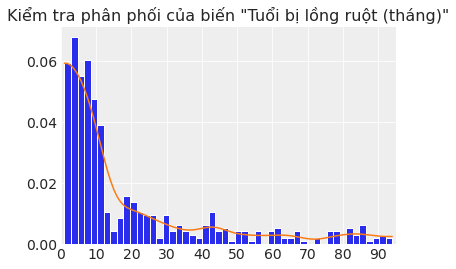

In [4]:
my_data_plot(data, title='Kiểm tra phân phối của biến "Tuổi bị lồng ruột (tháng)"')

## Các bạn thấy đó, phân phối này bị skew dương.  
Trong thống kê thì phân phối này rất thường gặp, khi đó, bạn cần phải transform biến bằng cách như logarith, v..v..

---
## Ước lượng trung bình và khoảng tin cậy bằng pp frequentist
- Áp dụng được với mọi loại phân phối, điều kiện là mẫu phải lớn.

In [5]:
n = len(data)
mean = data.mean()
sigma = data.std(ddof=1)
lower_bound = mean - 1.96*sigma/np.sqrt(n)
upper_bound = mean + 1.96*sigma/np.sqrt(n)
print(f"Trung bình: {mean:.2f}")
print(f"KTC 95%   : {lower_bound:.2f} -- {upper_bound:.2f}")

Trung bình: 19.70
KTC 95%   : 17.73 -- 21.68


- Có thể transform data trước để hợp logic hơn, khi đó phân phối giống normal hơn.

In [6]:
log_data = np.ones(data.shape)
np.log(data, out=log_data, where=data>0);

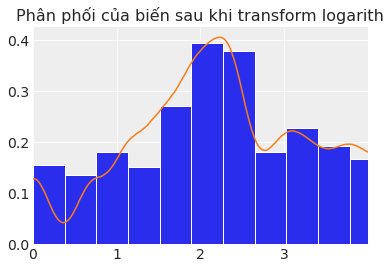

In [7]:
my_data_plot(log_data, bins=12, lim=5,title="Phân phối của biến sau khi transform logarith")

In [8]:
n = len(log_data)
mean = log_data.mean()
sigma = log_data.std(ddof=1)
lower_bound = mean - 1.96*sigma/np.sqrt(n)
upper_bound = mean + 1.96*sigma/np.sqrt(n)
print(f"Trung bình: {np.exp(mean):.2f}")
print(f"KTC 95%   : {np.exp(lower_bound):.2f} -- {np.exp(upper_bound):.2f}")

Trung bình: 10.44
KTC 95%   : 9.42 -- 11.56


==> Trung bình của `log_data` khác với trung bình của `data` bởi vì **Trung bình của `log_data` thực chất là trung vị của `data` gốc.**

---
## Ước lượng trung bình và khoảng tin cậy bằng pp Bayes

**Bước 1: Likelihood**  
- Ta chọn LogNormal vì phân phối này gần giống với phân phối của `data`.

**Bước 2: Prior**  
- Đặt 2 parameters `loc`, `scale` của LogNormal thông qua grid search
- Phương pháp đơn giản để chọn parameter là mô phỏng mẫu trước khi "thấy" dữ liệu thực.

**Bước 3:Lấy sample Posterior:**  
- MCMC, MAP_quadratic_approximation.

**Bước 4:Từ sample ta sẽ có trung bình, khoảng tin cậy v..v..**  

## Chọn prior cho các parameter `loc`, `scale` của lilelihood bằng pp Grid Search
#### Kiến thức chuyên môn:
>Sách của Bộ môn Ngoại nhi Đại học Y dược TP.HCM nói rằng LR có độ tuổi mắc phải chiếm 80-90% ở độ tuổi dưới 12 tháng.  
>Thường >6 tháng do thay đổi chế độ ăn.

In [9]:
from itertools import product
for loc, scale in product(np.arange(0, 5, 0.1), np.arange(0.1, 5, 0.1)):
    lognormal = dist.LogNormal(loc, scale)
    sample = lognormal.sample(PRNGKey(0),sample_shape=(1000,))
    lo, up = hpdi(sample, prob=0.8)
    if np.abs(12-up)<1 and lo >3:
        print(f"-----Với loc={loc:.2f}, scale={scale:.2f}")
        print(f"Median: {np.median(sample):.2f}", end=" "*10)
        print(f"KTC 80%: {lo:.2f} -- {up:.2f}")
        print()

-----Với loc=2.10, scale=0.40
Median: 8.12          KTC 80%: 3.81 -- 11.48

-----Với loc=2.10, scale=0.50
Median: 8.11          KTC 80%: 3.15 -- 12.51

-----Với loc=2.20, scale=0.20
Median: 9.00          KTC 80%: 6.98 -- 11.34

-----Với loc=2.20, scale=0.30
Median: 8.98          KTC 80%: 5.25 -- 11.78

-----Với loc=2.20, scale=0.40
Median: 8.97          KTC 80%: 4.21 -- 12.69

-----Với loc=2.30, scale=0.10
Median: 9.96          KTC 80%: 8.77 -- 11.18

-----Với loc=2.30, scale=0.20
Median: 9.94          KTC 80%: 7.71 -- 12.54

-----Với loc=2.40, scale=0.10
Median: 11.01          KTC 80%: 9.69 -- 12.36



## Có vẻ prior `loc=2.1, scale=0.5` là hợp lý.
Ta sẽ đặt
- `loc ~ Uniform(1,4)`
- `scale~ Exponential(1/0.5)` có trung bình là 0.5

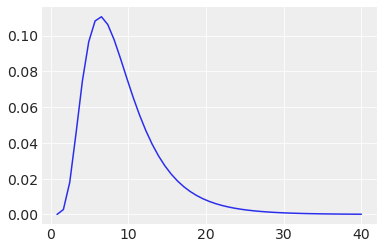

In [10]:
a = np.linspace(0,40)
lognormal = dist.LogNormal(2.1,0.5)
plt.plot(a, np.exp(lognormal.log_prob(a)));

## Bài này mình xin chạy MAP_quadratic_approximation để tìm posterior:
>Nó đơn giản là tìm đỉnh của posterior bằng gradient ascent và ước lượng sigma thông qua ma trận hessian blah, blah,..

Model:
$$\begin{align}
\text{age}  &\sim \text{LogNorm(loc, scale)}\\
\text{loc}  &\sim \text{Uniform(1, 4)}\\
\text{scale}  &\sim \text{Exponential(2)}
\end{align}$$

In [11]:
def model(age):
    # priors
    loc = numpyro.sample('loc', dist.Uniform(1,4))
    scale = numpyro.sample('scale', dist.Exponential(2))
    # likelihood
    numpyro.sample("age", dist.LogNormal(loc, scale), obs=age)

In [12]:
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, Adam(1), AutoContinuousELBO(),
          age=data)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
param = svi.get_params(state)
samples = guide.sample_posterior(PRNGKey(1), param, (1000,))

In [13]:
posterior = pd.DataFrame(summary(samples, 0.89, False)).T
posterior

,mean,std,median,5.5%,94.5%,n_eff,r_hat
loc,2.345120,0.050836,2.344470,2.259736,2.421217,994.498474,0.999000
scale,1.177941,0.037235,1.177862,1.123580,1.241333,1007.112048,0.999017


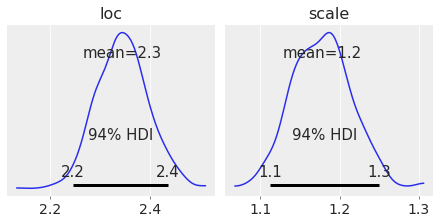

In [14]:
az.plot_posterior(samples, figsize=(6,3));

## Nhận xét:
- Các bạn thấy rằng với cỡ mẫu đủ lớn thì phân phối posterior gần như normal, không còn phụ thuộc vào phân phối của prior nữa.
- Tuy nhiên, việc đặt prior phù hợp vẫn quan trọng để tăng độ chính xác của suy luận Bayes.

---

## Ước lượng trung bình và khoảng tin cậy của trung bình bằng PP BOOTSTRAP:

Ta lấy 1000x1000 mẫu từ LogNormal với `loc=2.3, scale=1.2`. Tìm mean của 1000 mẫu đó, từ đó ra khoảng tin cậy của mean. 

In [15]:
posterior_age = dist.LogNormal(
    posterior.loc['loc','mean'],
    posterior.loc['scale','mean']
)

age_samples = posterior_age.sample(PRNGKey(1), sample_shape=(1000,1000))

In [16]:
mean_list = np.mean(age_samples, axis=0)
a,b,c = np.quantile(mean_list, (0.025, 0.5, 0.975))

print(f"Trung bình: {b:.2f}")
print(f"KTC 95%   : {a:.2f} - {c:.2f}")

Trung bình: 20.85
KTC 95%   : 18.95 - 23.31


## HOẶC trung vị và khoảng tin cậy của trung vị ( bởi vì pp LogNormal)

In [17]:
median_list = np.median(age_samples, axis=0)
a,b,c = np.quantile(median_list, (0.025, 0.5, 0.975))

print(f"Trung vị  : {b:.2f}")
print(f"KTC 95%   : {a:.2f} - {c:.2f}")

Trung vị  : 10.46
KTC 95%   : 9.52 - 11.52


---
# Ứng dụng của PP Bayes
## Một điểm hay của Bayes là ta có thể dùng nó để dự báo.
Với mỗi cặp `loc, scale`, ta cho vào LogNormal và lấy 1 mẫu. Mà ta có 1000 cặp như vậy => 1000 mẫu.   
Người ta gọi mẫu này là posterior predictive distribution.

In [18]:
predict_samples = dist.LogNormal(samples['loc'], samples['scale']).sample(PRNGKey(12))

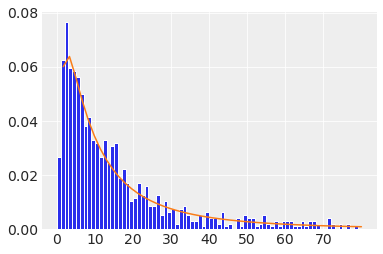

In [19]:
bins = 80
plt.hist(predict_samples,np.arange(bins), density=True, edgecolor='w')
a = np.linspace(0, bins)
plt.plot(a, np.exp(posterior_age.log_prob(a)))
plt.xticks(np.arange(0, bins,10));

- Xác suất một người mới bị lồng ruột có tuổi $\geq$ 5 tuổi?

In [20]:
sum(predict_samples > (5*12)) / 1000

0.089

- Xác suất một người mới bị lồng ruột có tuổi <3 tháng?

In [21]:
sum(predict_samples <3) / 1000

0.156

- Xác suất một người mới bị lồng ruột có tuổi từ 6 đến 18 tháng tuổi?

In [22]:
sum((predict_samples >6) & (predict_samples <18)) / 1000

0.36

- Trong `predict_samples` thì ai là người lớn tuổi nhất có thể bị lồng ruột?

In [23]:
print(np.max(predict_samples) /12)

48.43579


In [24]:
idx = np.argmax(predict_samples)
print(samples['loc'][idx], samples['scale'][idx])

2.3101928 1.1993271


## @.@ really? Have a nice day.